# CSE 598 Project Code
- Use GPU while running the model

## Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import multiprocessing
import torch.nn as nn
import torchvision
from torch.utils import model_zoo
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import gdown
import os.path
from os import path

In [2]:
# dataloader for ImageNet
def loader_imgnet(dir_data, nb_images = 50000, batch_size = 100, img_size = 224):
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])
    
    val_dataset = ImageFolder(dir_data, val_transform)
    
    # Random subset if not using the full 50,000 validation set
    if nb_images < 50000:
        np.random.seed(0)
        sample_indices = np.random.permutation(range(50000))[:nb_images]
        val_dataset = Subset(val_dataset, sample_indices)
    
    dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size = batch_size,                              
        shuffle = True, 
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    )
    
    return dataloader


# dataloader for CIFAR-10
def loader_cifar(dir_data, train = False, batch_size = 250):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if train:
        trainset = torchvision.datasets.CIFAR10(root = dir_data, train = True, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    else:
        testset = torchvision.datasets.CIFAR10(root = dir_data, train = False, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    return dataloader


# Evaluate model on data with or without UAP
# Assumes data range is bounded by [0, 1]
def evaluate(model, loader, uap = None, n = 5):
    '''
    OUTPUT
    top         top n predicted labels (default n = 5)
    top_probs   top n probabilities (default n = 5)
    top1acc     array of true/false if true label is in top 1 prediction
    top5acc     array of true/false if true label is in top 5 prediction
    outputs     output labels
    labels      true labels
    '''
    probs, labels = [], []
    model.eval()
    
    if uap is not None:
        _, (x_val, y_val) = next(enumerate(loader))
        batch_size = len(x_val)
        uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    
    with torch.set_grad_enabled(False):
        for i, (x_val, y_val) in enumerate(loader):
            
            if uap is None:
                out = torch.nn.functional.softmax(model(x_val.cuda()), dim = 1)
            else:
                perturbed = torch.clamp((x_val + uap).cuda(), 0, 1) # clamp to [0, 1]
                out = torch.nn.functional.softmax(model(perturbed), dim = 1)
                
            probs.append(out.cpu().numpy())
            labels.append(y_val)
            
    # Convert batches to single numpy arrays    
    probs = np.stack([p for l in probs for p in l])
    labels = np.array([t for l in labels for t in l])
    
    # Extract top 5 predictions for each example
    top = np.argpartition(-probs, n, axis = 1)[:,:n]
    top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float16)
    top1acc = top[range(len(top)), np.argmax(top_probs, axis = 1)] == labels
    top5acc = [labels[i] in row for i, row in enumerate(top)]
    outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]
        
    return top, top_probs, top1acc, top5acc, outputs, labels


In [3]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [4]:
class Block(nn.Module):
    '''expand + depthwise + pointwise + squeeze-excitation'''

    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0():
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)

In [5]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [7]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [8]:
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

IMGNET_MEAN = [0.485, 0.456, 0.406]
IMGNET_STD = [0.229, 0.224, 0.225]


class Normalizer(nn.Module):
    def __init__(self, mean, std):
        super(Normalizer, self).__init__()
        if not isinstance(mean, torch.Tensor):
            mean = torch.tensor(mean)
        if not isinstance(std, torch.Tensor):
            std = torch.tensor(std)
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)
        
    def forward(self, tensor):
        return normalize_fn(tensor, self.mean, self.std)
    
    def extra_repr(self):
        return 'mean={}, std={}'.format(self.mean, self.std)
    

def normalize_fn(tensor, mean, std):
    """
    Differentiable version of torchvision.functional.normalize
    - default assumes color channel is at dim = 1
    """
    mean = mean[None, :, None, None]
    std = std[None, :, None, None]
    return tensor.sub(mean).div(std)


'''
Load pre-trained ImageNet models

For models pre-trained on Stylized-ImageNet:
[ICLR 2019] ImageNet-trained CNNs are biased towards texture; increasing shape bias improves accuracy and robustness
Paper: https://openreview.net/forum?id=Bygh9j09KX
Code: https://github.com/rgeirhos/texture-vs-shape
'''    
def model_imgnet(model_name):
    '''
    model_name options:
    resnet50_SIN       trained on Stylized only
    resnet50_SIN-IN    trained on ImageNet + Stylized
    resnet50_SIN-2IN   trained on ImageNet + Stylized, then fine-tuned on ImageNet
    
    or load torchvision.models pre-trained on ImageNet: https://pytorch.org/docs/stable/torchvision/models.html
    '''
    
    if model_name[:12] == 'resnet50_SIN':
        model_urls = {
            'resnet50_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar',
            'resnet50_SIN-IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar',
            'resnet50_SIN-2IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar',
        }
        model = torchvision.models.resnet50(pretrained=False)
        model = nn.DataParallel(model).cuda()
        checkpoint = model_zoo.load_url(model_urls[model_name])
        model.load_state_dict(checkpoint['state_dict'])
        
    # Load pre-trained ImageNet models from torchvision
    else:
        model = eval("torchvision.models.{}(pretrained=True)".format(model_name))
        model = nn.DataParallel(model).cuda()
    
    # Normalization wrapper, so that we don't have to normalize adversarial perturbations
    normalize = Normalizer(mean = IMGNET_MEAN, std = IMGNET_STD)
    model = nn.Sequential(normalize, model)
    model = model.cuda()
    print("Model loading complete.")
    
    return model


# Load pre-trained CIFAR-10 models
def model_cifar(model_name, ckpt_path):
    '''
    CIFAR-10 model implementations from:
    https://github.com/kuangliu/pytorch-cifar
    '''
    if model_name == 'resnet18':
        model = ResNet18()
    elif model_name == 'vgg16':
        model = VGG('VGG16')
        
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    
    # Load saved weights and stats
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    
    # Normalization wrapper, so that we don't have to normalize adversarial perturbations
    normalize = Normalizer(mean = CIFAR_MEAN, std = CIFAR_STD)
    model = nn.Sequential(normalize, model)
    model = model.cuda()

    return model, best_acc


# dataloader for ImageNet
def loader_imgnet(dir_data, nb_images = 50000, batch_size = 100, img_size = 224):
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])
    
    val_dataset = ImageFolder(dir_data, val_transform)
    
    # Random subset if not using the full 50,000 validation set
    if nb_images < 50000:
        np.random.seed(0)
        sample_indices = np.random.permutation(range(50000))[:nb_images]
        val_dataset = Subset(val_dataset, sample_indices)
    
    dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size = batch_size,                              
        shuffle = True, 
        num_workers = max(1, multiprocessing.cpu_count() - 1)
    )
    
    return dataloader


# dataloader for CIFAR-10
def loader_cifar(dir_data, train = False, batch_size = 250):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if train:
        trainset = torchvision.datasets.CIFAR10(root = dir_data, train = True, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    else:
        testset = torchvision.datasets.CIFAR10(root = dir_data, train = False, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    return dataloader


# Evaluate model on data with or without UAP
# Assumes data range is bounded by [0, 1]
def evaluate(model, loader, uap = None, n = 5):
    '''
    OUTPUT
    top         top n predicted labels (default n = 5)
    top_probs   top n probabilities (default n = 5)
    top1acc     array of true/false if true label is in top 1 prediction
    top5acc     array of true/false if true label is in top 5 prediction
    outputs     output labels
    labels      true labels
    '''
    probs, labels = [], []
    model.eval()
    
    if uap is not None:
        _, (x_val, y_val) = next(enumerate(loader))
        batch_size = len(x_val)
        uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    
    with torch.set_grad_enabled(False):
        for i, (x_val, y_val) in enumerate(loader):
            
            if uap is None:
                out = torch.nn.functional.softmax(model(x_val.cuda()), dim = 1)
            else:
                perturbed = torch.clamp((x_val + uap).cuda(), 0, 1) # clamp to [0, 1]
                out = torch.nn.functional.softmax(model(perturbed), dim = 1)
                
            probs.append(out.cpu().numpy())
            labels.append(y_val)
            
    # Convert batches to single numpy arrays    
    probs = np.stack([p for l in probs for p in l])
    labels = np.array([t for l in labels for t in l])
    
    # Extract top 5 predictions for each example
    top = np.argpartition(-probs, n, axis = 1)[:,:n]
    top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float16)
    top1acc = top[range(len(top)), np.argmax(top_probs, axis = 1)] == labels
    top5acc = [labels[i] in row for i, row in enumerate(top)]
    outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]
        
    return top, top_probs, top1acc, top5acc, outputs, labels


In [9]:
def uap_sgd(model, loader, nb_epoch, eps, beta = 12, step_decay = 0.8, y_target = None, loss_fn = None, layer_name = None, uap_init = None):
    '''
    INPUT
    model       model
    loader      dataloader
    nb_epoch    number of optimization epochs
    eps         maximum perturbation value (L-infinity) norm
    beta        clamping value
    y_target    target class label for Targeted UAP variation
    loss_fn     custom loss function (default is CrossEntropyLoss)
    layer_name  target layer name for layer maximization attack
    uap_init    custom perturbation to start from (default is random vector with pixel values {-eps, eps})
    
    OUTPUT
    delta.data  adversarial perturbation
    losses      losses per iteration
    '''
    _, (x_val, y_val) = next(enumerate(loader))
    # model.to('cuda')
    device = next(model.parameters()).device
    device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('device: ', device, device2)
    batch_size = len(x_val)
    if uap_init is None:
        print('init false')
        # batch_delta = torch.zeros_like(x_val) # initialize as zero vector
        # batch_delta = torch.zeros_like(x_val).to(device) 
        batch_delta = torch.zeros_like(x_val, requires_grad=True).cuda()
        # batch_delta = torch.zeros_like(x_val)
        # batch_delta.retain_grad()
    else:
        print('init true')
        batch_delta = uap_init.unsqueeze(0).repeat([batch_size, 1, 1, 1]).to(device)
    
    delta = batch_delta[0]
    # print('delta: ', delta)
    losses = []
    
    # loss function
    if layer_name is None:
        print('handle if')
        if loss_fn is None: loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        beta = torch.cuda.FloatTensor([beta]).to(device)
        def clamped_loss(output, target):
            loss = torch.mean(torch.min(loss_fn(output, target), beta))
            # loss_min = torch.min(loss_fn(output, target))
            # if loss_min.numel() == 0:
            #     loss = torch.tensor([0.0], requires_grad=True)
            # else:
            #     loss = torch.mean(torch.min(loss_min, beta))
            return loss
    
    # layer maximization attack
    else:
        print('handle else')
        def get_norm(self, forward_input, forward_output):
            global main_value
            main_value = torch.norm(forward_output, p = 'fro')
        # handle = None
        for name, layer in model.named_modules():
            if name == layer_name:
                handle = layer.register_forward_hook(get_norm)
                
    batch_delta = batch_delta.to(device).requires_grad_()
    
    # print(batch_delta.grad, type(batch_delta))
    for epoch in range(nb_epoch):
        print('epoch %i/%i' % (epoch + 1, nb_epoch))
        
        # perturbation step size with decay
        eps_step = eps * step_decay
        
        # with torch.no_grad():
        for i, (x_val, y_val) in enumerate(loader):
            # print('here1')
            if batch_delta.grad is not None:
                batch_delta.grad.data.zero_()
            else:
                batch_delta.grad = torch.zeros_like(batch_delta).to(device)

            # batch_delta.grad.data.zero_()
            # batch_delta.grad = None
            # print('here2')
            batch_delta.data = delta.unsqueeze(0).repeat([x_val.shape[0], 1, 1, 1])

            # for targeted UAP, switch output labels to y_target
            if y_target is not None: y_val = torch.ones(size = y_val.shape, dtype = y_val.dtype) * y_target
            
            perturbed = torch.clamp((x_val.cuda() + batch_delta).cuda(), 0, 1)
            outputs = model(perturbed)
            
            # loss function value
            if layer_name is None: loss = clamped_loss(outputs, y_val.cuda())
            else: loss = main_value
            
            if y_target is not None: loss = -loss # minimize loss for targeted UAP
            losses.append(torch.mean(loss))
            loss.backward()
            # print(loss.shape, loss.dtype)
            
            # batch update
            grad_sign = batch_delta.grad.data.mean(dim = 0).sign()
            delta = delta + grad_sign * eps_step
            delta = torch.clamp(delta, -eps, eps)
            batch_delta.grad.data.zero_()
    
    if layer_name is not None: handle.remove() # release hook
    
    return delta.data, losses

## CIFAR

In [10]:
# !gdown --id 1HimV7njf1XYwdiFi4okT-IGYL5sqidWy
# gdown.download_folder('https://drive.google.com/drive/folders/1HimV7njf1XYwdiFi4okT-IGYL5sqidWy?usp=share_link', quiet=True)

In [11]:
# testloader = loader_cifar(dir_data = 'cifar10', train = False)

In [12]:
# trainloader = loader_cifar(dir_data = 'cifar10', train = True)

In [13]:
# !gdown --id 1Aj0Q3loc2adoJDkB_2jQqMArMBu-gurS
# gdown.download('https://drive.google.com/file/d/1Aj0Q3loc2adoJDkB_2jQqMArMBu-gurS', 'resnet18.pth', quiet=True)

In [14]:
# model, best_acc = model_cifar('resnet18', ckpt_path = 'resnet18.pth')

## ImageNet

In [15]:
dir_data = 'data/'
dir_uap = 'uaps/imagenet/'

In [16]:
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

--2023-02-27 23:19:45--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6.3G) [application/x-tar]
Saving to: ‘ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6.28G  10.7MB/s    in 12m 51s 

2023-02-27 23:32:37 (8.34 MB/s) - ‘ILSVRC2012_img_val.tar’ saved [6744924160/6744924160]



In [17]:
!mkdir data

In [18]:
!tar -xf  'ILSVRC2012_img_val.tar' -C 'data/'

In [19]:
%cd "data/"
# !ls

/content/data


In [20]:
!wget -qO- https://raw.githubusercontent.com/soumith/imagenetloader.torch/master/valprep.sh | bash

In [21]:
# !ls

In [22]:
%cd ..

/content


In [23]:
loader = loader_imgnet(dir_data, 2000, 100)

In [24]:
model = model_imgnet('resnet50')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Model loading complete.


### Clean accuracy (ResNet50)

In [25]:
# clean accuracy
_, _, _, _, outputs, labels = evaluate(model, loader)
print('Accuracy:', sum(outputs == labels) / len(labels))

Accuracy: 0.782


### Untargeted UAP (ResNet50)

In [26]:
nb_epoch = 10
eps = 10 / 255
beta = 12
step_decay = 0.7
# Generate UAP and losses
# uap, losses = uap_sgd(model, loader, nb_epoch, eps, beta, step_decay)

In [38]:
gdown.download_folder("https://drive.google.com/drive/folders/1SIMn5WFZyyS_ZWYxfBNELL8A6W1sCz80", quiet=True, remaining_ok=True)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Ugct9qBT4cQW67ydWK14ZeOp7I1rtTnu 



In [39]:
uap_resnet50_untargeted = torch.load(dir_uap + 'sgd-resnet50-eps10.pth')

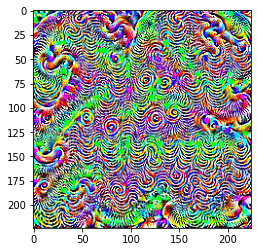

In [40]:
uap_max = torch.max(uap_resnet50_untargeted)
plt.imshow(np.transpose(((uap_resnet50_untargeted / uap_max) + 1) / 2, (1, 2, 0)))

In [41]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, loader, uap = uap_resnet50_untargeted)
print('Accuracy:', sum(outputs == labels) / len(labels))

Accuracy: 0.061


In [52]:
# dir_uap = 'uaps/imagenet/'
uap_vgg16_untargeted = torch.load(dir_uap + 'sgd-vgg16-eps10.pth')

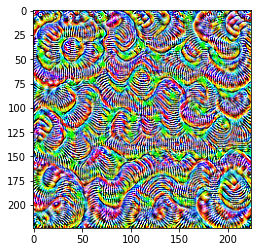

In [53]:
uap_max = torch.max(uap_vgg16_untargeted)
plt.imshow(np.transpose(((uap_vgg16_untargeted / uap_max) + 1) / 2, (1, 2, 0)))

### Targeted UAP (ResNet50)

In [44]:
# load pattern
y_target = 859
uap_resnet_50 = torch.load(dir_uap + 'sgd-tgt%i-resnet50-eps10.pth' % y_target)

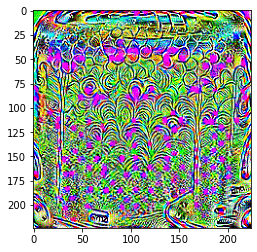

In [45]:
# visualize
uap_max = torch.max(uap_resnet_50)
plt.imshow(np.transpose(((uap_resnet_50 / uap_max) + 1) / 2, (1, 2, 0)))

In [46]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, loader, uap = uap_resnet_50)
print('Accuracy:', sum(outputs == labels) / len(labels))
print('Targeted success rate:', sum(outputs == y_target) / len(labels))

Accuracy: 0.196
Targeted success rate: 0.6275


### Targeted UAP (ResNet18)

In [47]:
dir_uap = 'uaps/cifar10/'

# load UAP targeting class 4 with eps = 10
y_target = 4
eps = 10
uap_resnet_18 = torch.load(dir_uap + 'sgd-tgt%i-eps%i.pth' % (y_target, eps))

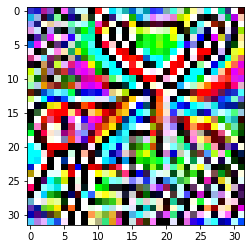

In [48]:
# visualize UAP
uap_max = torch.max(uap_resnet_18)
plt.imshow(np.transpose(((uap_resnet_18 / uap_max) + 1) / 2, (1, 2, 0)))

In [49]:
# evaluate
# _, _, _, _, outputs, labels = evaluate(model, testloader, uap = uap) # model is not available as we were not able to train the model by ourselves
# print('Accuracy:', sum(outputs == labels) / len(labels))
# print('Targeted success rate:', sum(outputs == y_target) / len(labels))

## Combining UAPs

In [42]:
# Combining Untargeted UAPs for our experiment
lambda_array = np.linspace(0, 1, 21)
lambda_array

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [70]:
def combine_UAPs(uap_1, uap_2, lmbd):
    first_term = uap_1.multiply(lmbd)
    second_term = uap_2.multiply(1-lmbd)
    result = first_term.add(second_term)
    return result

Lambda value :---> 0.0
Accuracy: 0.516


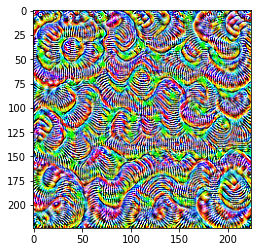

Lambda value :---> 0.05
Accuracy: 0.5435


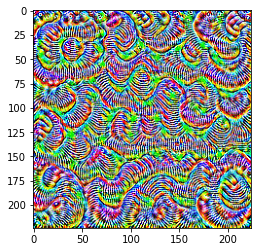

Lambda value :---> 0.1
Accuracy: 0.569


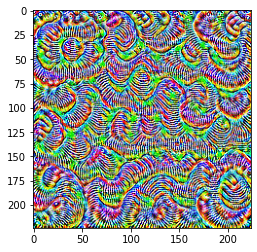

Lambda value :---> 0.15000000000000002
Accuracy: 0.598


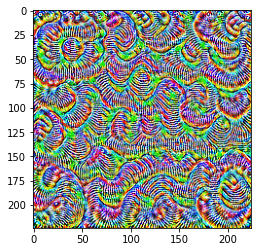

Lambda value :---> 0.2
Accuracy: 0.6215


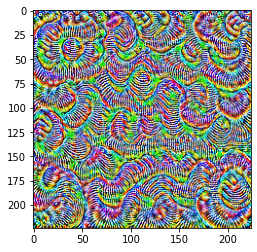

Lambda value :---> 0.25
Accuracy: 0.643


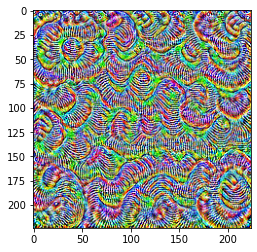

Lambda value :---> 0.30000000000000004
Accuracy: 0.6545


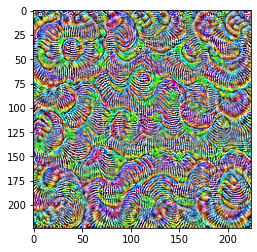

Lambda value :---> 0.35000000000000003
Accuracy: 0.6625


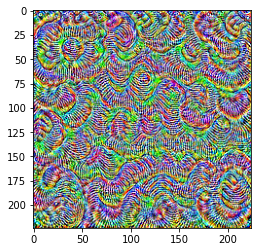

Lambda value :---> 0.4
Accuracy: 0.657


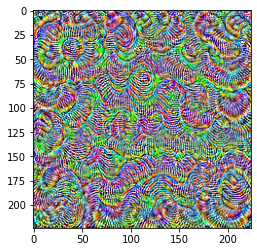

Lambda value :---> 0.45


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc76fa7a0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Accuracy: 0.6345


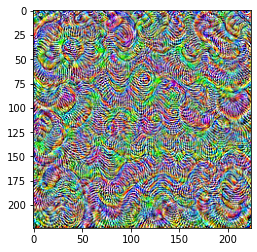

Lambda value :---> 0.5
Accuracy: 0.5855


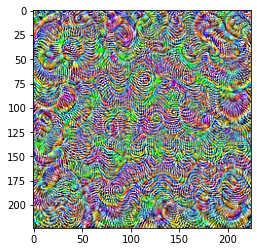

Lambda value :---> 0.55
Accuracy: 0.515


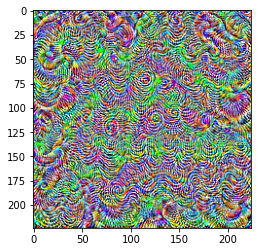

Lambda value :---> 0.6000000000000001
Accuracy: 0.425


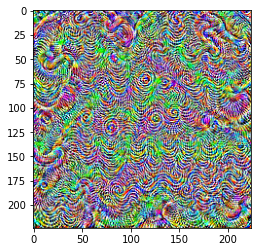

Lambda value :---> 0.65
Accuracy: 0.34


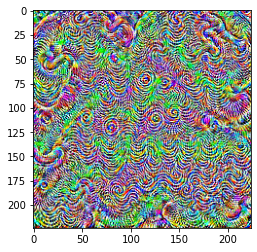

Lambda value :---> 0.7000000000000001
Accuracy: 0.266


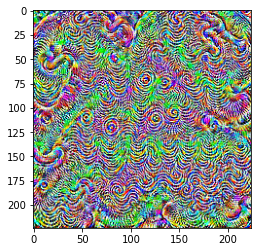

Lambda value :---> 0.75
Accuracy: 0.207


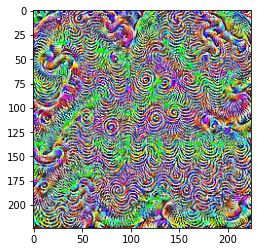

Lambda value :---> 0.8
Accuracy: 0.157


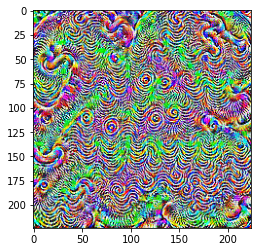

Lambda value :---> 0.8500000000000001
Accuracy: 0.126


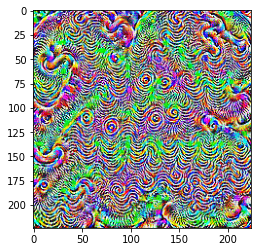

Lambda value :---> 0.9
Accuracy: 0.102


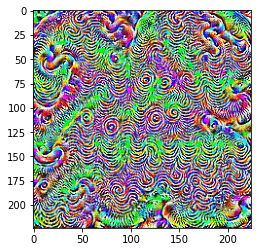

Lambda value :---> 0.9500000000000001
Accuracy: 0.0775


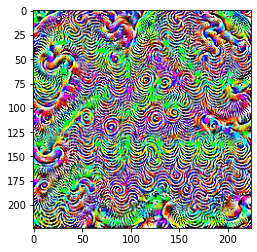

Lambda value :---> 1.0
Accuracy: 0.061


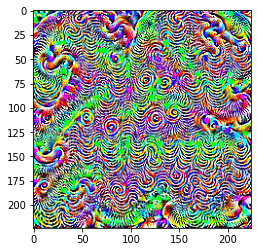

In [71]:
for lmd in lambda_array:
    print('Lambda value :--->', lmd)
    combined_uap = combine_UAPs(uap_resnet50_untargeted, uap_vgg16_untargeted, lmd)
    
    # Show
    uap_max = torch.max(combined_uap)
    plt.imshow(np.transpose(((combined_uap / uap_max) + 1) / 2, (1, 2, 0)))

    # Evaluate
    _, _, _, _, outputs, labels = evaluate(model, loader, uap = combined_uap)
    print('Accuracy:', sum(outputs == labels) / len(labels))

    plt.pause(0.0001)

We can see that accuracy of the combined UAPs is as effective as the individual model and it increases for value of lambda ranging from 0 till 0.4, and then starts to decrease from 0.4 till 1.